In [2]:
# Audio pre-processor

from ntpath import isdir
import librosa
import numpy as np
import pandas as pd
import subprocess
import os
import glob

config = {
    'target_sr': 22050,
    'duration': 3,
    'overlap_ratio': 0.5,
}

class AudioProcessor:

    def __init__(self, config):
        self.config = config
        self.target_sr = config['target_sr']
        self.duration = config['duration']
        self.overlap_ratio = config['overlap_ratio']

    def load_audio(self, file_path):
        """load audio / optionally convert mp3 to wav for lossless processing"""
        # wav_file = file_path.replace('.mp3', '.wav')
        # subprocess.run(['ffmpeg', '-i', file_path, wav_file], check=True)
        audio, sr = librosa.load(file_path)
        return audio, sr
    
    def chunk_audio(self, audio):
        """chunk audio into 3 seconds chunks with 50% overlap"""
        chunk_len = int(self.target_sr * self.duration)
        hop_len = int(chunk_len * (1 - self.overlap_ratio))
        chunks = []
        for start_idx in range(0, len(audio) - chunk_len + 1, hop_len):
            end_idx = start_idx + chunk_len
            chunk = audio[start_idx:end_idx]
            chunks.append(chunk)
        return chunks

    def calculate_snr(self, chunks):
        """calculate snr of each chunk"""
        snr = []
        for chunk in chunks:
            rms = np.sqrt(np.mean(chunk ** 2))
            snr.append(rms)
        return snr
    
    def extract_patient_info(self, patient_dir):
        patient_info = {
            'name': None,
            'age': None,
            'gender': None,
            'condition': None,
        }
        try:
            parts = patient_dir.strip().split('-')
            # name-age-gender-condition
            patient_info['name'] = parts[0].strip()
            age_str = parts[1].strip()
            if age_str:
                patient_info['age'] = int(age_str)
            gender = parts[2].strip()
            clean_gender = ''.join(filter(str.isalpha, gender)).lower()
            if clean_gender in ['m', 'male']:
                patient_info['gender'] = 'Male'
            elif clean_gender in ['f', 'female']:
                patient_info['gender'] = 'Female'
            else:
                patient_info['gender'] = None
            if len(parts) > 3:
                patient_info['condition'] = '-'.join(parts[3:]).strip()

        except Exception as e:
            print(f"Error extracting patient info from {patient_dir}: {e}") 
        return patient_info


def load_dataset(data_dir):
    processor = AudioProcessor(config)
    dataset = []

    # process benign directory
    benign_dir = os.path.join(data_dir, 'Benign')
    if os.path.exists(benign_dir):
        for patient_folder in os.listdir(benign_dir):
            patient_dir = os.path.join(os.path.join(benign_dir, patient_folder))
            if os.path.isdir(patient_dir):
                for audio_file in glob.glob(os.path.join(patient_dir, '*.mp3')) + \
                                  glob.glob(os.path.join(patient_dir, '*.m4a')):
                    
                    audio, sr = processor.load_audio(audio_file)
                    if audio is not None:
                        chunks = processor.chunk_audio(audio)
                        patient_info = processor.extract_patient_info(patient_folder)
                        for chunk in chunks:
                            dataset.append({
                                'filepath': audio_file,
                                'name': patient_info['name'],
                                'age': patient_info['age'],
                                'gender': patient_info['gender'],
                                'condition': patient_info['condition'],
                                'audio': chunk,
                                'label': 'benign',
                            })

    # process malignant directory
    malignant_dir = os.path.join(data_dir, 'Malignant')
    if os.path.exists(malignant_dir):
        for patient_folder in os.listdir(malignant_dir):
            patient_dir = os.path.join(os.path.join(malignant_dir, patient_folder))
            if os.path.isdir(patient_dir):
                for audio_file in glob.glob(os.path.join(patient_dir, '*.mp3')) + \
                                  glob.glob(os.path.join(patient_dir, '*.m4a')):
                    
                    audio, sr = processor.load_audio(audio_file)
                    if audio is not None:
                        chunks = processor.chunk_audio(audio)
                        patient_info = processor.extract_patient_info(patient_folder)
                        for chunk in chunks:
                            dataset.append({
                                'filepath': audio_file,
                                'name': patient_info['name'],
                                'age': patient_info['age'],
                                'gender': patient_info['gender'],
                                'condition': patient_info['condition'],
                                'audio': chunk,
                                'label': 'malignant',
                            })
    
    return pd.DataFrame(dataset)

data_dir = '/Users/mudi/voice-model/data/'
print("Loading dataset...")
df = load_dataset(data_dir)
print(f"Dataset loaded with {len(df)} samples")


Loading dataset...


Note: Illegal Audio-MPEG-Header 0x3139392c at offset 2412480.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
/var/folders/sd/zywz_szx6rd500k_lds9thtr0000gn/T/ipykernel_3066/3210629527.py:29: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path)
/Users/mudi/voice-model/venv/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/sd/zywz_szx6rd500k_lds9thtr0000gn/T/ipykernel_3066/3210629527.py:29: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path)
/Users/mudi/voice-model/venv/lib/python3.9/site-packages/librosa/core/audio.py:1

Dataset loaded with 3385 samples


Note: Illegal Audio-MPEG-Header 0x20000034 at offset 162240.
Note: Trying to resync...
Note: Skipped 932 bytes in input.
Note: Illegal Audio-MPEG-Header 0x2c323934 at offset 654692.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).


In [3]:
print("Dataset loaded with {} samples".format(len(df)))

df.head()

Dataset loaded with 3385 samples


,filepath,name,age,gender,condition,audio,label
0,/Users/mudi/voice-model/data/Benign/Kallu-61-m...,Kallu,61,Male,normal,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",benign
1,/Users/mudi/voice-model/data/Benign/Kallu-61-m...,Kallu,61,Male,normal,"[-0.08061759, -0.07485202, -0.06794332, -0.060...",benign
2,/Users/mudi/voice-model/data/Benign/Kallu-61-m...,Kallu,61,Male,normal,"[0.25835726, 0.29439008, 0.3185393, 0.33363545...",benign
3,/Users/mudi/voice-model/data/Benign/Kallu-61-m...,Kallu,61,Male,normal,"[-0.072752364, -0.073502176, -0.07258043, -0.0...",benign
4,/Users/mudi/voice-model/data/Benign/Kallu-61-m...,Kallu,61,Male,normal,"[0.008563278, 0.005528689, -0.0016295097, -0.0...",benign


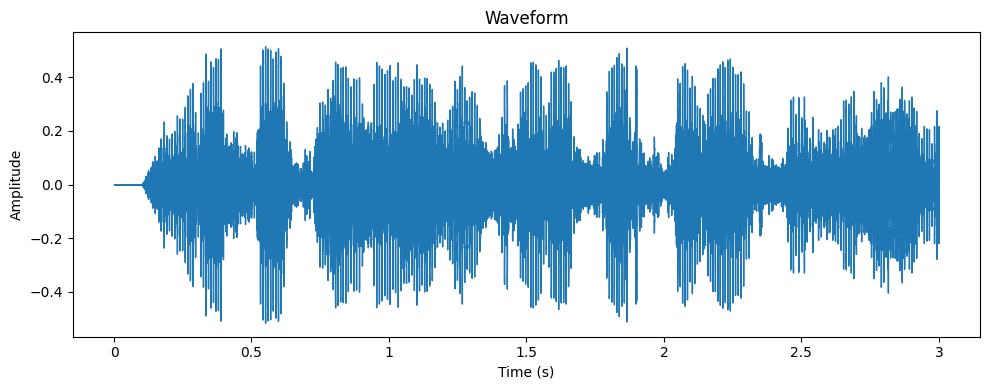

In [4]:
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import display

def get_audio(sample):
    return ipd.Audio(sample['audio'], rate=config['target_sr'])

def get_waveform(sample):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(sample['audio'], sr=config['target_sr'])
    plt.title("Waveform")
    plt.ylabel("Amplitude")
    plt.xlabel("Time (s)")
    plt.tight_layout()

# plot a sample audio
sample = df.iloc[0]
display(get_audio(sample))
get_waveform(sample)


In [5]:
meta = []
for (i, row) in df.iterrows():
    meta.append({
        "duration": librosa.get_duration(y=row['audio'], sr=config['target_sr']),
        "rms_frames": librosa.feature.rms(y=row['audio'], frame_length=1024, hop_length=256)[0],
        "rms_mean": float(np.mean(librosa.feature.rms(y=row['audio'], frame_length=1024, hop_length=256)[0])),
    })

meta_df = pd.DataFrame(meta, index=df.index)
df = df.join(meta_df)


In [6]:
df

,filepath,name,age,gender,condition,audio,label,duration,rms_frames,rms_mean
0,/Users/mudi/voice-model/data/Benign/Kallu-61-m...,Kallu,61,Male,normal,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",benign,3.0,"[0.0, 0.0, 0.0, 0.0, 1.8090068e-11, 5.936132e-...",0.109704
1,/Users/mudi/voice-model/data/Benign/Kallu-61-m...,Kallu,61,Male,normal,"[-0.08061759, -0.07485202, -0.06794332, -0.060...",benign,3.0,"[0.08462434, 0.107285336, 0.12321454, 0.125827...",0.096332
2,/Users/mudi/voice-model/data/Benign/Kallu-61-m...,Kallu,61,Male,normal,"[0.25835726, 0.29439008, 0.3185393, 0.33363545...",benign,3.0,"[0.10480093, 0.12441592, 0.1336843, 0.11214607...",0.076253
3,/Users/mudi/voice-model/data/Benign/Kallu-61-m...,Kallu,61,Male,normal,"[-0.072752364, -0.073502176, -0.07258043, -0.0...",benign,3.0,"[0.07855168, 0.09159955, 0.10098764, 0.0969109...",0.077182
4,/Users/mudi/voice-model/data/Benign/Kallu-61-m...,Kallu,61,Male,normal,"[0.008563278, 0.005528689, -0.0016295097, -0.0...",benign,3.0,"[0.019158028, 0.023275172, 0.026526375, 0.0278...",0.082019
...,...,...,...,...,...,...,...,...,...,...
3380,/Users/mudi/voice-model/data/Malignant/Om prak...,Om prakash,60,Male,growth right arytenoid,"[0.011843082, 0.0070835124, -0.0008037811, -0....",malignant,3.0,"[0.009589234, 0.012316292, 0.014562053, 0.0149...",0.084688
3381,/Users/mudi/voice-model/data/Malignant/Om prak...,Om prakash,60,Male,growth right arytenoid,"[-0.033707835, -0.020389043, -0.03266992, -0.0...",malignant,3.0,"[0.055170253, 0.07473263, 0.087915726, 0.09624...",0.056227
3382,/Users/mudi/voice-model/data/Malignant/Om prak...,Om prakash,60,Male,growth right arytenoid,"[0.044163488, 0.07511073, 0.07966412, 0.040748...",malignant,3.0,"[0.04592136, 0.05141637, 0.053670548, 0.045002...",0.031617
3383,/Users/mudi/voice-model/data/Malignant/Om prak...,Om prakash,60,Male,growth right arytenoid,"[-0.0014025698, -0.003107961, -0.0017735133, -...",malignant,3.0,"[0.0055607143, 0.006853795, 0.007628627, 0.007...",0.058888


In [7]:
df.describe()

,age,duration,rms_mean
count,3385.000000,3385.0,3385.000000
mean,46.816544,3.0,0.084979
std,12.188326,0.0,0.034428
min,15.000000,3.0,0.007538
25%,39.000000,3.0,0.056662
50%,50.000000,3.0,0.086592
75%,56.000000,3.0,0.109854
max,69.000000,3.0,0.200013


<Axes: xlabel='label'>

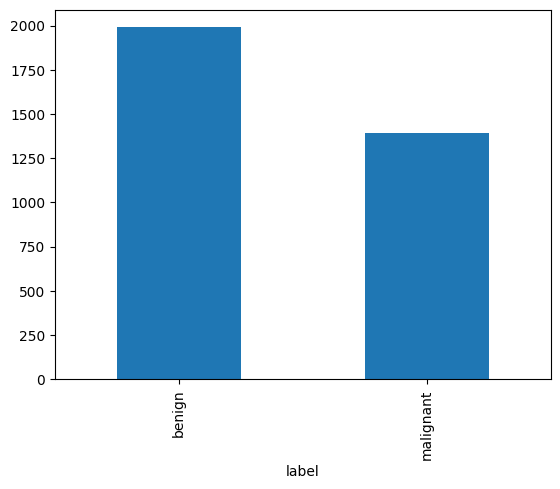

In [8]:
df['label'].value_counts().plot(kind='bar')

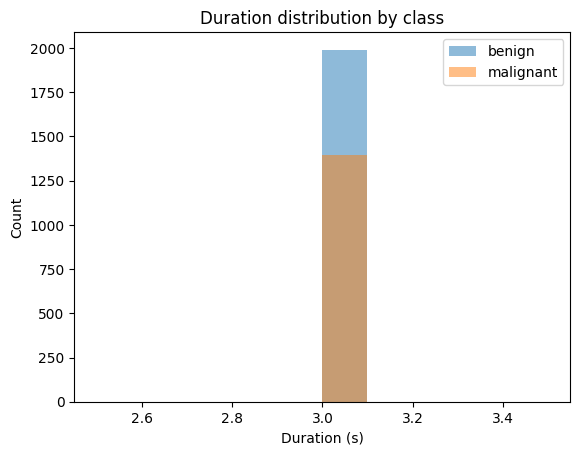

In [9]:
def duration_distribution(df):
    plt.hist(df[df.label=="benign"]["duration"], alpha=0.5, label="benign")
    plt.hist(df[df.label=="malignant"]["duration"], alpha=0.5, label="malignant")
    plt.xlabel("Duration (s)")
    plt.ylabel("Count")
    plt.legend()
    plt.title("Duration distribution by class")
    plt.show()

duration_distribution(df)

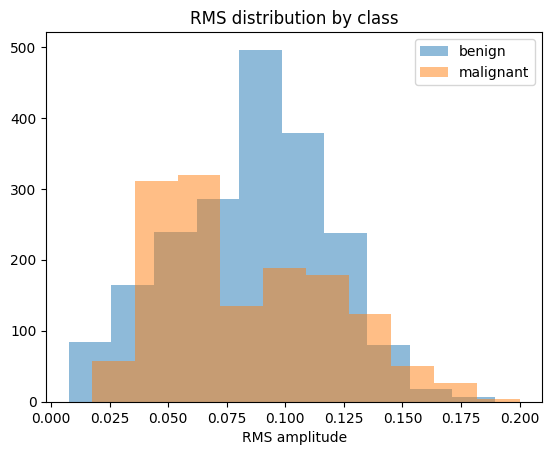

In [10]:
def rms_distribution(df):
    plt.hist(df[df.label=="benign"]["rms_mean"], alpha=0.5, label="benign")
    plt.hist(df[df.label=="malignant"]["rms_mean"], alpha=0.5, label="malignant")
    plt.xlabel("RMS amplitude")
    plt.legend()
    plt.title("RMS distribution by class")
    plt.show()
"""
RMS amplitude distributions for benign and malignant voices are broadly similar,
with benign voices slightly louder on average. The strong overlap suggests RMS alone is not a reliable classifier,
 but the small shift and absence of extreme outliers indicate reasonably consistent recording levels across groups.
"""
rms_distribution(df)

In [11]:
def snr_from_rms_frames(row, noise_frac=0.1, signal_frac=0.5):
    rms = row['rms_frames']
    if rms is None or len(rms) == 0:
        return np.nan

    rms = np.asarray(rms, dtype=float)
    rms_sorted = np.sort(rms)
    n = len(rms_sorted)

    # noise: bottom noise_frac
    n_noise = max(1, int(noise_frac * n))
    noise_rms = np.mean(rms_sorted[:n_noise])

    # signal: top signal_frac
    start_signal = int((1.0 - signal_frac) * n)
    signal_rms = np.mean(rms_sorted[start_signal:])

    return 20 * np.log10((signal_rms + 1e-12) / (noise_rms + 1e-12))

df['snr_db'] = df.apply(snr_from_rms_frames, axis=1)


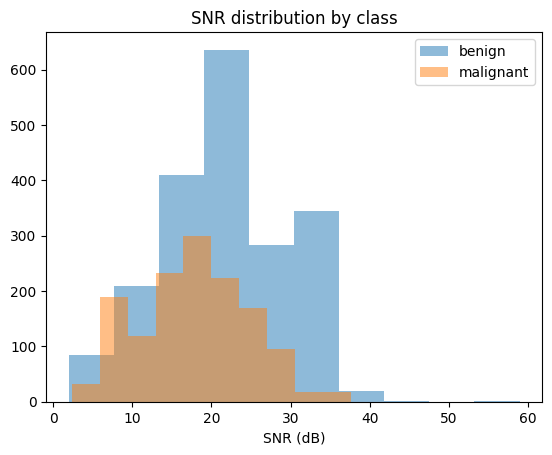

(367, 11)
updated dataset shape:  (3018, 11)


In [12]:
def snr_distribution(df):
    plt.hist(df[df.label=="benign"]["snr_db"], alpha=0.5, label="benign")
    plt.hist(df[df.label=="malignant"]["snr_db"], alpha=0.5, label="malignant")
    plt.xlabel("SNR (dB)")
    plt.legend()
    plt.title("SNR distribution by class")
    plt.show()

snr_distribution(df)

sample_low_snr_frames = df[df['snr_db'] < 10]
print(sample_low_snr_frames.shape)
# print(sample_low_snr_frames.head())
# get_waveform(.iloc[0])

# drop low snr frames
clean_df = df[df['snr_db'] > 10]
print("updated dataset shape: ", clean_df.shape)




In [13]:
# extract f0 features
# adult male fq range - 85 - 180Hz and female 165 - 255Hz
import parselmouth
from parselmouth import praat
from scipy import signal
from tqdm import tqdm


def compute_f0_features(audio, sr, f_max = 500, f_min = 75):
    f0 = librosa.yin(audio, fmin = f_min, fmax = f_max, sr = sr)
    if f0.size == 0:
        return {k: np.nan for k in ["f0_mean","f0_median","f0_min","f0_max","f0_sd","f0_range"]}
    return {
        "f0_mean": float(np.mean(f0)),
        "f0_median": float(np.median(f0)),
        "f0_min": float(np.min(f0)),
        "f0_max": float(np.max(f0)),
        "f0_sd": float(np.std(f0)),
        "f0_range": float(np.max(f0) - np.min(f0)),
    }

def compute_praat_measures(audio, sr):
    sound = parselmouth.Sound(audio, sampling_frequency = sr)
    point_process = praat.call(sound, 'To PointProcess (periodic, cc)', 75, 500)
    # jitter
    jitter_local = praat.call(point_process, 'Get jitter (local)', 0, 0, 0.0001, 0.02, 1.3)
    jitter_rap = praat.call(point_process, 'Get jitter (rap)', 0, 0, 0.0001, 0.02, 1.3)
    # shimmer
    shimmer_local = praat.call([sound, point_process], 'Get shimmer (local)', 0, 0, 0.0001, 0.02, 1.3, 1.6)
    shimmer_apq3 = praat.call([sound, point_process], 'Get shimmer (apq3)', 0, 0, 0.0001, 0.02, 1.3, 1.6)
    shimmer_apq5 = praat.call([sound, point_process], 'Get shimmer (apq5)', 0, 0, 0.0001, 0.02, 1.3, 1.6)
    # hnr
    hnr = praat.call(sound, 'To Harmonicity (cc)', 0.01, 75, 0.1, 1.0)
    hnr_mean = praat.call(hnr, 'Get mean', 0, 0)
    # cpp
    cp = praat.call(sound, "To PowerCepstrogram", 60, 0.002, 5000, 50)
    cpps = praat.call(cp, "Get CPPS", "yes", 0.01, 0.001, 60, 330, 0.05, "parabolic", 0.001, 0.05, "Straight", "Robust")
    #cpp_mean = praat.call(cpps, "Get mean", 0, 0)
    return dict(
        jitter_local = float(jitter_local),
        jitter_rap = float(jitter_rap),
        shimmer_local = float(shimmer_local),
        shimmer_apq3 = float(shimmer_apq3),
        shimmer_apq5 = float(shimmer_apq5),
        hnr_mean = float(hnr_mean),
        cpp_mean = float(cpps),
    )

def spectral_features(y, sr):
    S = np.abs(librosa.stft(y, n_fft=2048, hop_length=512))
    # basic stuff
    centroid = librosa.feature.spectral_centroid(S=S, sr=sr).mean()
    flatness = librosa.feature.spectral_flatness(S=S).mean()
    zcr      = librosa.feature.zero_crossing_rate(y).mean()
    rolloff  = librosa.feature.spectral_rolloff(S=S, sr=sr, roll_percent=0.85).mean()
    return dict(
        spectral_centroid=float(centroid),
        spectral_flatness=float(flatness),
        zcr=float(zcr),
        spectral_rolloff_85=float(rolloff),
    )

def ltas_bands(y, sr):
    freqs, Pxx = signal.welch(y, fs=sr, nperseg=4096)
    total = np.trapz(Pxx, freqs) + 1e-12
    def band_pct(a, b):
        mask = (freqs >= a) & (freqs < b)
        energy = np.trapz(Pxx[mask], freqs[mask])
        return float(100.0 * energy / total)
    return dict(
        ltas_0_1k = band_pct(0, 1000),
        ltas_1_2k = band_pct(1000, 2000),
        ltas_2_4k = band_pct(2000, 4000),
        ltas_4_8k = band_pct(4000, 8000),
    )


def extract_features_from_audio(row):
    audio = row['audio']
    sr = config['target_sr']
    feats = {
        "filepath": row['filepath'],
        "audio": row['audio'],
        "label": row['label'],
        "duration": row['duration'],
        "rms_mean": row['rms_mean'],
        "snr_db": row['snr_db'],
    }
    feats.update(compute_f0_features(audio, sr))
    feats.update(compute_praat_measures(audio, sr))
    feats.update(spectral_features(audio, sr))
    feats.update(ltas_bands(audio, sr))
    return feats

clean_df.head()
rows = []
for _, row in tqdm(clean_df.iterrows(), total = len(clean_df)):
    rows.append(extract_features_from_audio(row))

feat_df = pd.DataFrame(rows)
feat_df.head()


  0%|          | 0/3018 [00:00<?, ?it/s]/var/folders/sd/zywz_szx6rd500k_lds9thtr0000gn/T/ipykernel_3066/2734223782.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(Pxx, freqs) + 1e-12
/var/folders/sd/zywz_szx6rd500k_lds9thtr0000gn/T/ipykernel_3066/2734223782.py:68: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  energy = np.trapz(Pxx[mask], freqs[mask])
100%|██████████| 3018/3018 [08:54<00:00,  5.65it/s]


,filepath,audio,label,duration,rms_mean,snr_db,f0_mean,f0_median,f0_min,f0_max,...,hnr_mean,cpp_mean,spectral_centroid,spectral_flatness,zcr,spectral_rolloff_85,ltas_0_1k,ltas_1_2k,ltas_2_4k,ltas_4_8k
0,/Users/mudi/voice-model/data/Benign/Kallu-61-m...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",benign,3.0,0.109704,16.177136,121.449882,107.472727,75.000000,501.136364,...,8.335426,6.264989,897.562927,0.023970,0.036873,1469.723933,98.568980,1.259917,0.129312,0.020651
1,/Users/mudi/voice-model/data/Benign/Kallu-61-m...,"[-0.08061759, -0.07485202, -0.06794332, -0.060...",benign,3.0,0.096332,10.561737,115.529185,108.848916,77.637251,255.805688,...,7.872327,6.127983,882.980275,0.000903,0.036659,1492.168157,98.315148,1.412802,0.215867,0.037278
2,/Users/mudi/voice-model/data/Benign/Kallu-61-m...,"[0.25835726, 0.29439008, 0.3185393, 0.33363545...",benign,3.0,0.076253,11.136527,109.358392,106.118415,95.692801,219.593571,...,7.730614,5.789435,993.848651,0.001171,0.037680,1836.036846,97.617416,1.871088,0.395205,0.095036
3,/Users/mudi/voice-model/data/Benign/Kallu-61-m...,"[-0.072752364, -0.073502176, -0.07258043, -0.0...",benign,3.0,0.077182,12.117860,110.750599,106.316951,93.924135,219.011544,...,7.481905,5.575543,1006.625901,0.001421,0.039622,1840.674767,98.088216,1.459908,0.353454,0.076887
4,/Users/mudi/voice-model/data/Benign/Kallu-61-m...,"[0.008563278, 0.005528689, -0.0016295097, -0.0...",benign,3.0,0.082019,13.590878,108.864793,106.359939,75.000000,192.685840,...,8.086744,6.182560,923.260910,0.001370,0.036527,1601.242112,97.852049,1.944197,0.170312,0.016940


In [14]:
feat_df.columns

Index(['filepath', 'audio', 'label', 'duration', 'rms_mean', 'snr_db',
       'f0_mean', 'f0_median', 'f0_min', 'f0_max', 'f0_sd', 'f0_range',
       'jitter_local', 'jitter_rap', 'shimmer_local', 'shimmer_apq3',
       'shimmer_apq5', 'hnr_mean', 'cpp_mean', 'spectral_centroid',
       'spectral_flatness', 'zcr', 'spectral_rolloff_85', 'ltas_0_1k',
       'ltas_1_2k', 'ltas_2_4k', 'ltas_4_8k'],
      dtype='object')

In [25]:
features_df = feat_df.copy()

y = (features_df["label"] == "malignant").astype(int)
groups = features_df["filepath"]
X = features_df.drop(columns=["label", "audio", "filepath", "duration"])

X.isna().sum().sort_values()

features_df["label"].value_counts()

# X.dropna(inplace = True)


label
benign       1865
malignant    1153
Name: count, dtype: int64

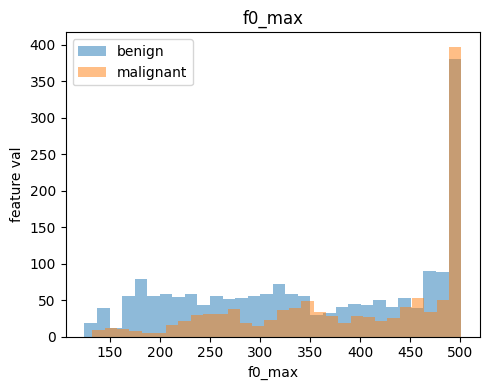

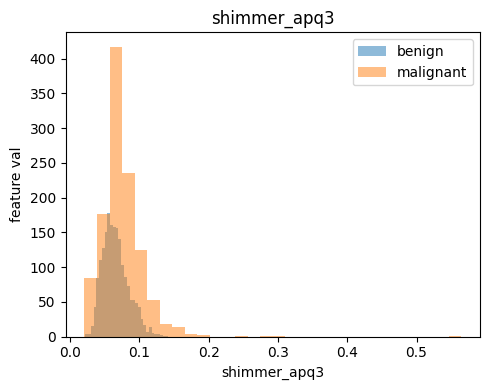

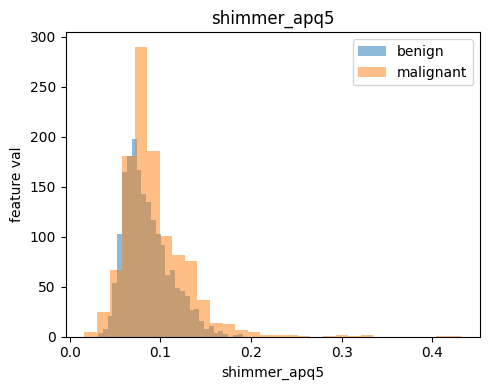

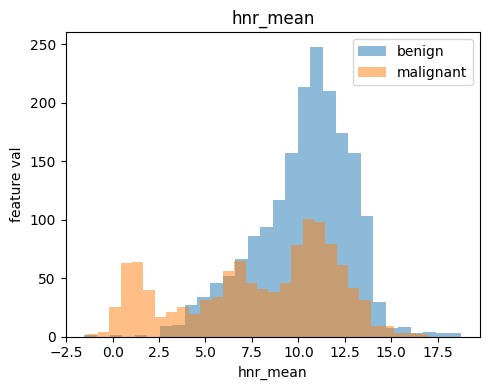

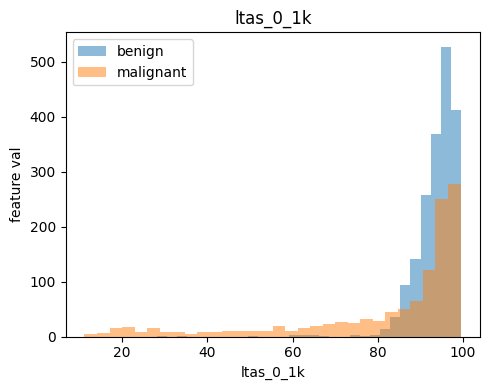

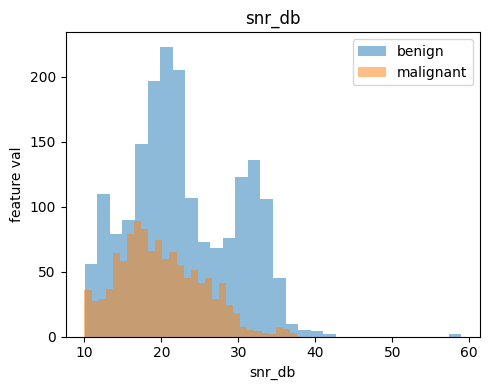

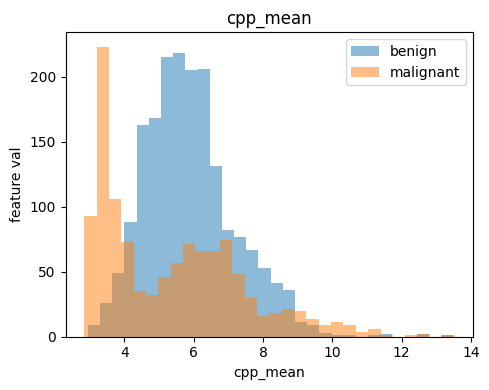

In [26]:
def plot_hist_by_label(df, feature, bins=30):
    plt.figure(figsize=(5,4))
    for lab, color in zip(["benign", "malignant"], ["tab:blue", "tab:orange"]):
        vals = df[df["label"] == lab][feature].dropna().values
        plt.hist(vals, bins=bins, alpha=0.5, label=lab)
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel("feature val")
    plt.legend()
    plt.tight_layout()
    plt.show()

for feat in ["f0_max", "shimmer_apq3", "shimmer_apq5", "hnr_mean", "ltas_0_1k", "snr_db", "cpp_mean"]:
    if feat in features_df.columns:
        plot_hist_by_label(features_df, feat)

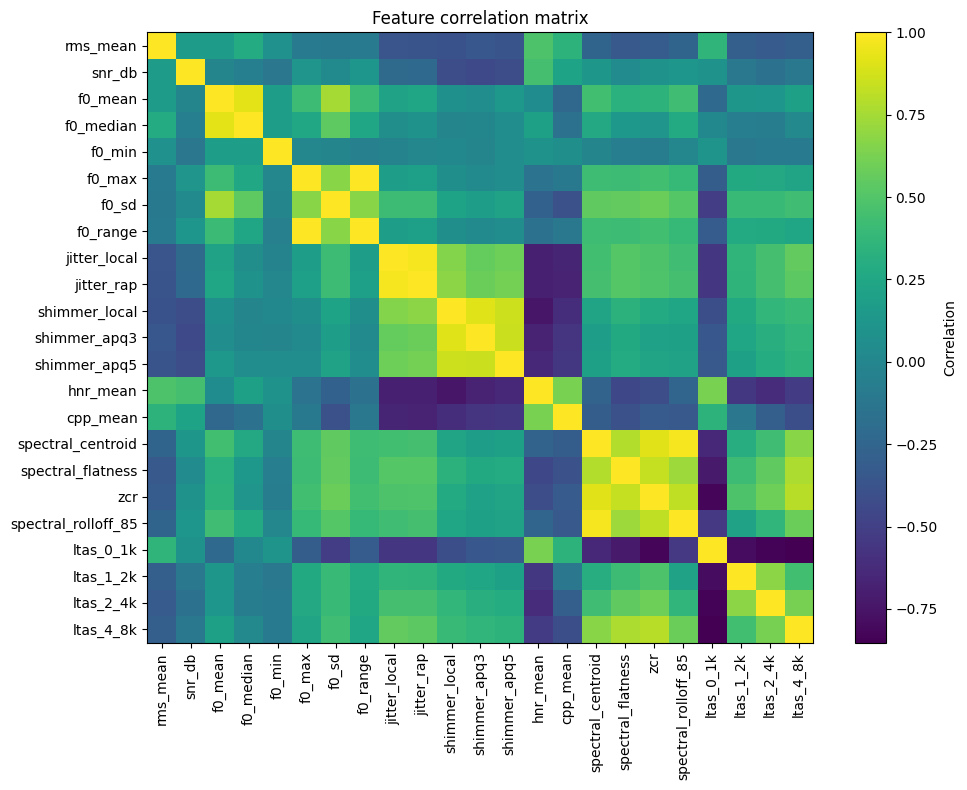

In [17]:
num_cols = [c for c in X.columns if X[c].dtype != object]
corr = X[num_cols].corr()

plt.figure(figsize=(10,8))
plt.imshow(corr, aspect="auto")
plt.colorbar(label="Correlation")
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Feature correlation matrix")
plt.tight_layout()
plt.show()

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(test_size=0.25, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.values[train_idx], X.values[test_idx]
y_train, y_test = y.values[train_idx], y.values[test_idx]

pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", penalty="l2")),
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

Confusion matrix:
 [[322 149]
 [136 131]]

Classification report:
               precision    recall  f1-score   support

      benign       0.70      0.68      0.69       471
   malignant       0.47      0.49      0.48       267

    accuracy                           0.61       738
   macro avg       0.59      0.59      0.59       738
weighted avg       0.62      0.61      0.62       738

AUROC: 0.630620959469453


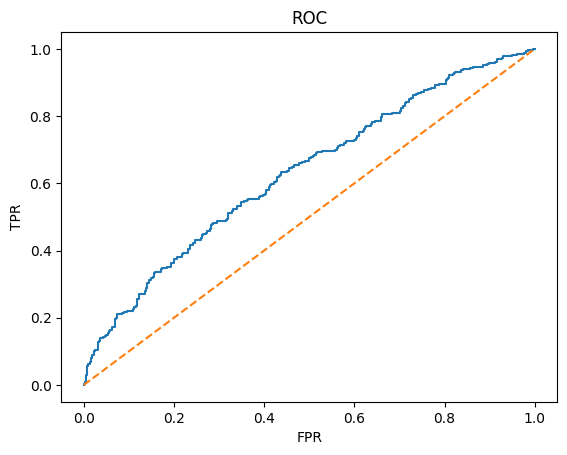

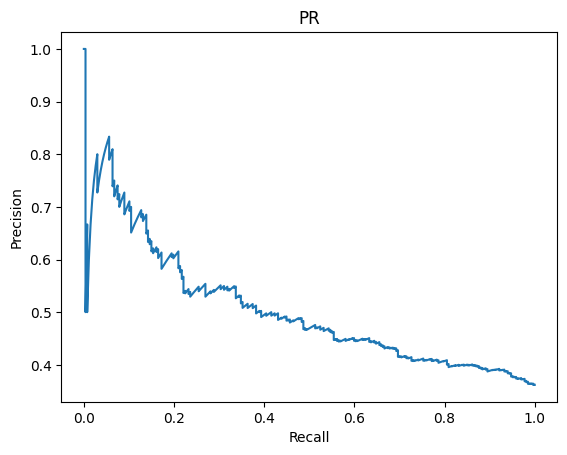

In [19]:
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt

def plot_metrics(X_test, y_test, pipe):
    y_prob = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= 0.5).astype(int)

    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification report:\n",
        classification_report(y_test, y_pred, target_names=["benign","malignant"]))
    print("AUROC:", roc_auc_score(y_test, y_prob))

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.show()

    # PR
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(rec, prec); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR"); plt.show()

plot_metrics(X_test, y_test, pipe)


In [20]:
# using selected features - 

selected_cols = ["f0_max", "shimmer_apq3", "shimmer_apq5", "cpp_mean", "ltas_0_1k"]
X_sel = X[selected_cols].values

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_sel, y.values, test_size=0.25, random_state=42, stratify=y
)

pipe_sel = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        penalty="l2"
    )),
])

pipe_sel.fit(X_train_sel, y_train_sel)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

Confusion matrix:
 [[342 125]
 [149 139]]

Classification report:
               precision    recall  f1-score   support

      benign       0.70      0.73      0.71       467
   malignant       0.53      0.48      0.50       288

    accuracy                           0.64       755
   macro avg       0.61      0.61      0.61       755
weighted avg       0.63      0.64      0.63       755

AUROC: 0.6759160123721151


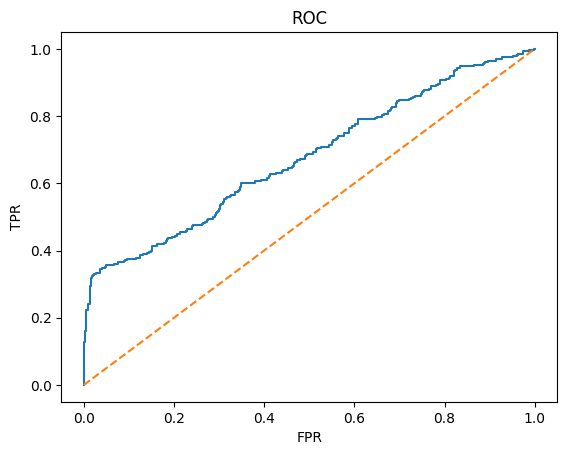

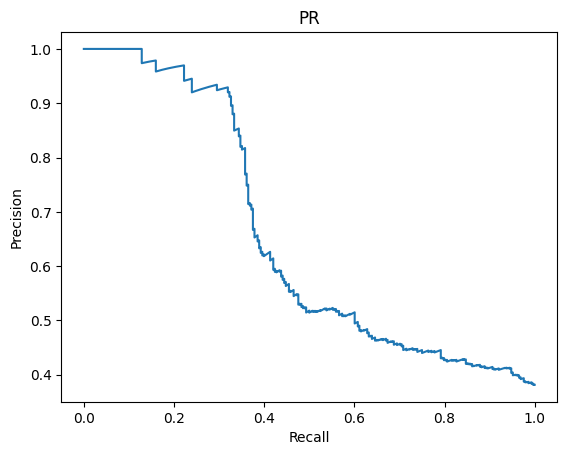

In [21]:
plot_metrics(X_test_sel, y_test_sel, pipe_sel)

Confusion matrix:
 [[370 101]
 [238  29]]

Classification report:
               precision    recall  f1-score   support

      benign       0.61      0.79      0.69       471
   malignant       0.22      0.11      0.15       267

    accuracy                           0.54       738
   macro avg       0.42      0.45      0.42       738
weighted avg       0.47      0.54      0.49       738

AUROC: 0.4793609898454957


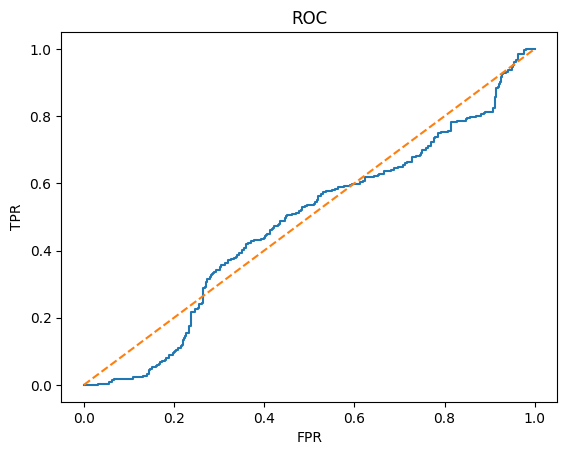

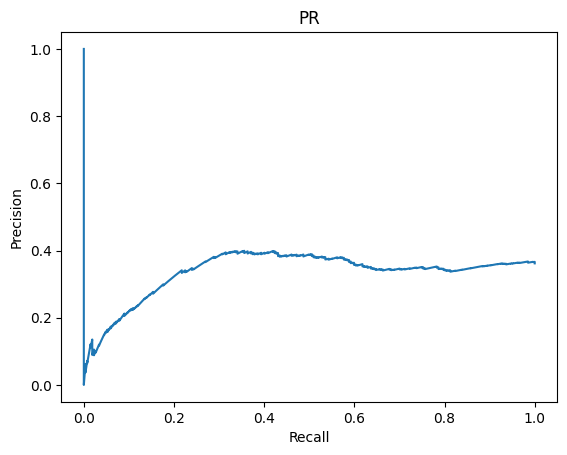

In [22]:
# xg boost
from xgboost import XGBClassifier
from sklearn.model_selection import GroupShuffleSplit

xgb_df = features_df.copy()

xgb_y = (xgb_df["label"] == "malignant").astype(int)
groups = features_df["filepath"]
xgb_X = xgb_df.drop(columns=["label", "audio", "filepath", "duration", "rms_mean", "snr_db"])


# xgb_X_train, xgb_X_test, xgb_y_train, xgb_y_test = train_test_split(
#     xgb_X.values, xgb_y.values, test_size=0.25, random_state=42, stratify=xgb_y
# )

gss = GroupShuffleSplit(test_size=0.25, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(xgb_X, xgb_y, groups=groups))

xgb_X_train, xgb_X_test = xgb_X.values[train_idx], xgb_X.values[test_idx]
xgb_y_train, xgb_y_test = xgb_y.values[train_idx], xgb_y.values[test_idx]

imputer = SimpleImputer(strategy="median")
xgb_X_train = imputer.fit_transform(xgb_X_train)
xgb_X_test = imputer.transform(xgb_X_test)

neg, pos = np.bincount(xgb_y_train)
scale_pos_weight = neg / pos

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
)

xgb.fit(
    xgb_X_train, xgb_y_train,
    eval_set=[(xgb_X_train, xgb_y_train), (xgb_X_test, xgb_y_test)],
    verbose=False,
)

plot_metrics(xgb_X_test, xgb_y_test, xgb)